# all converted to MongoDB

In [40]:
from pymongo import MongoClient
from collections import Counter

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Replace 'your_database' with your actual database name
collection = db['reports']  # Replace 'your_collection' with your actual collection name

In [41]:
import numpy as np
# Define function to categorize age
def categorize_age(age):
    if pd.isna(age) or age < 0: # Check for NaN or negative values
        return 'Unknown'
    if age < 1/12:  # Neonate: less than 1 month
        return 'Neonate'
    elif age < 2:  # Infant: less than 2 years
        return 'Infant'
    elif age < 12:  # Child: less than 12 years
        return 'Child'
    elif age < 18:  # Adolescent: less than 18 years
        return 'Adolescent'
    elif age < 65:  # Adult: less than 65 years
        return 'Adult'
    else:  # Elderly: 65 years and older
        return 'Elderly'

# Vaccine entries by manufacturer (2020 - 2023)

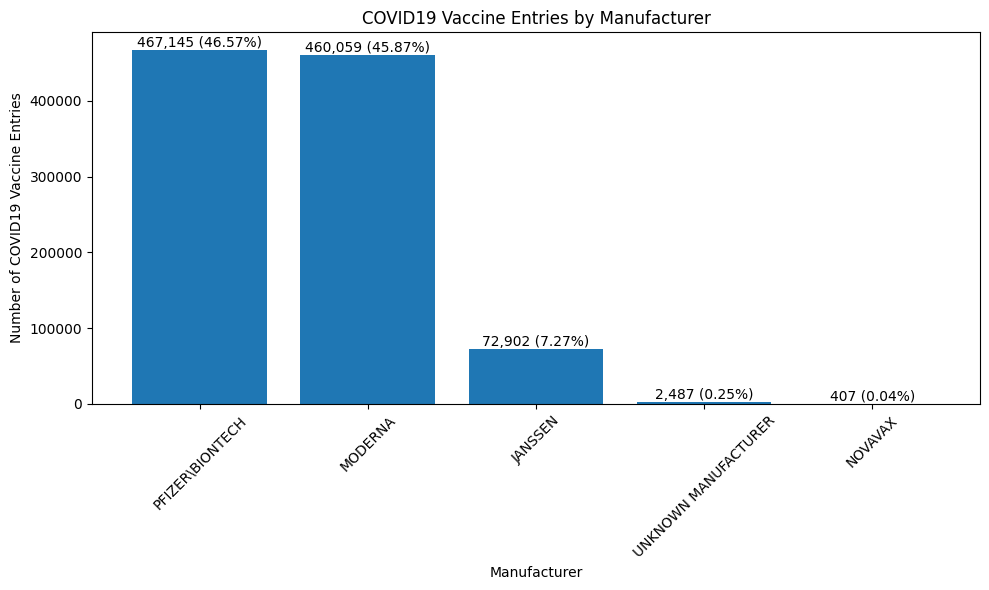

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store counts of COVID19 vaccines by manufacturer
covid_vax_counts = {}

# Query MongoDB for documents containing COVID19 vaccine data
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1}
documents_cursor = collection.find(query, projection)

# Count COVID19 vaccine entries by manufacturer
total_entries = 0
for document in documents_cursor:
    covid_vax_entry = None
    # Iterate through vaccine entries in reverse order to find the last COVID-19 vaccine
    for entry in reversed(document.get("vax_data", [])):
        if "VAX_MANU" in entry and "VAX_TYPE" in entry and "COVID19" in entry["VAX_TYPE"].upper():
            covid_vax_entry = entry
            break  # Stop iterating once the last COVID-19 vaccine entry is found
    if covid_vax_entry:
        manufacturer = covid_vax_entry["VAX_MANU"]
        covid_vax_counts[manufacturer] = covid_vax_counts.get(manufacturer, 0) + 1
        total_entries += 1

# Sort the dictionary by counts in decreasing order
sorted_covid_vax_counts = dict(sorted(covid_vax_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_covid_vax_counts.keys(), sorted_covid_vax_counts.values())

plt.xlabel('Manufacturer')
plt.ylabel('Number of COVID19 Vaccine Entries')
plt.title('COVID19 Vaccine Entries by Manufacturer')
plt.xticks(rotation=45)

# Annotate each bar with its value and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_entries) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Entries_by_Manufacturer.png')
plt.show()

In [43]:
document

{'_id': ObjectId('65d3b33a6b9531e46fc6a080'),
 'vax_data': [{'VAX_TYPE': 'COVID19',
   'VAX_MANU': 'MODERNA',
   'VAX_LOT': '067H21A',
   'VAX_DOSE_SERIES': '1',
   'VAX_NAME': 'COVID19 (COVID19 (MODERNA))'}]}

# Deaths by manufacturer (2020 - 2023)

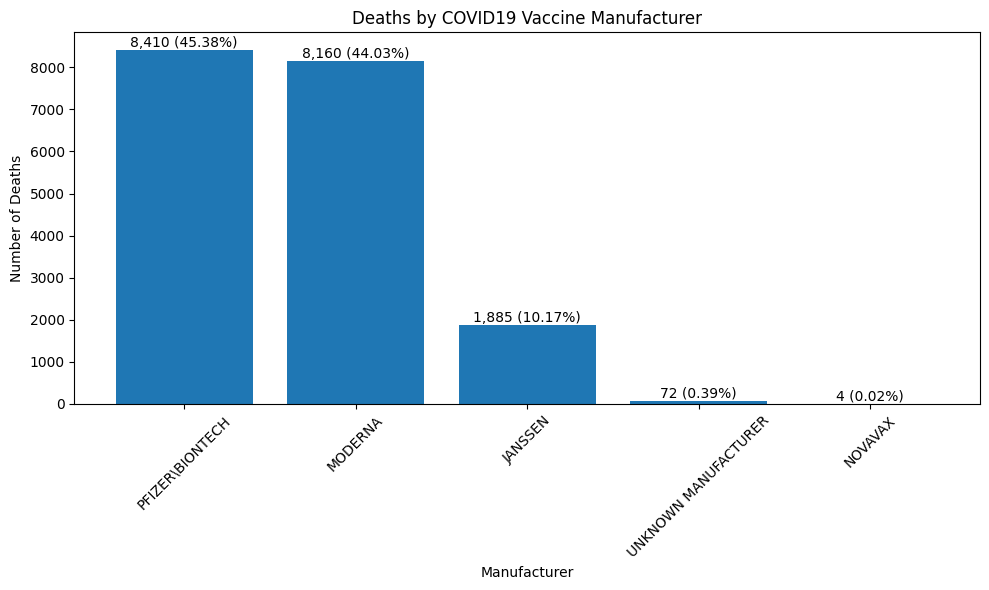

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store counts of deaths by COVID19 vaccine manufacturer
deaths_per_manufacturer = {}

# Initialize total entries counter
total_deaths = 0

# Query MongoDB for documents containing COVID19 vaccine data and projection optimization
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1, "_id": 0}  # Projection optimization
documents_cursor = collection.find(query, projection)

# Count deaths by COVID19 vaccine manufacturer
for document in documents_cursor:
    covid_vax_entry = document.get("vax_data", [])[-1]  # Access the last entry directly
    if covid_vax_entry and "VAX_MANU" in covid_vax_entry and "DIED" in document:
        manufacturer = covid_vax_entry["VAX_MANU"]
        if document["DIED"] == "Y":
            deaths_per_manufacturer[manufacturer] = deaths_per_manufacturer.get(manufacturer, 0) + 1
            total_deaths += 1

# Sort the dictionary by counts in decreasing order
sorted_deaths_per_manufacturer = dict(sorted(deaths_per_manufacturer.items(), key=lambda item: item[1], reverse=True))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_deaths_per_manufacturer.keys(), sorted_deaths_per_manufacturer.values())

plt.xlabel('Manufacturer')
plt.ylabel('Number of Deaths')
plt.title('Deaths by COVID19 Vaccine Manufacturer')
plt.xticks(rotation=45)

# Annotate each bar with its value and percentage
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_deaths) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Manufacturer.png')
plt.show()


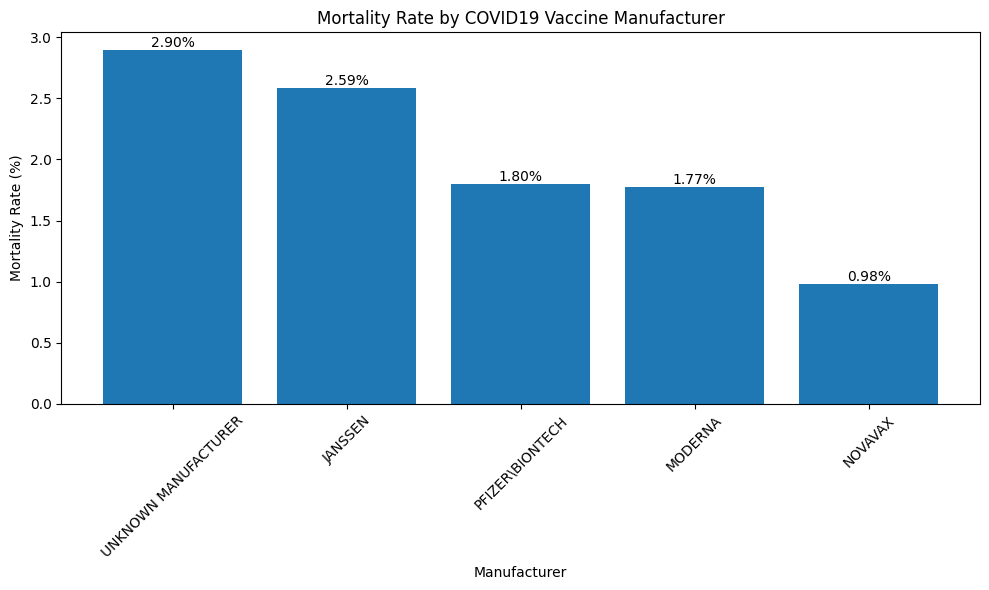

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store counts of deaths by COVID19 vaccine manufacturer
deaths_per_manufacturer = {}
vaccinations_per_manufacturer = {}

# Initialize total deaths and total vaccinations counters
total_deaths = 0
total_vaccinations = 0

# Query MongoDB for documents containing COVID19 vaccine data and projection optimization
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1, "_id": 0}  # Projection optimization
documents_cursor = collection.find(query, projection)

# Count deaths and vaccinations by COVID19 vaccine manufacturer
for document in documents_cursor:
    covid_vax_entry = document.get("vax_data", [])[-1]  # Access the last entry directly
    if covid_vax_entry and "VAX_MANU" in covid_vax_entry:
        manufacturer = covid_vax_entry["VAX_MANU"]
        vaccinations_per_manufacturer[manufacturer] = vaccinations_per_manufacturer.get(manufacturer, 0) + 1
        total_vaccinations += 1
        if "DIED" in document and document["DIED"] == "Y":
            deaths_per_manufacturer[manufacturer] = deaths_per_manufacturer.get(manufacturer, 0) + 1
            total_deaths += 1

# Calculate mortality rate for each manufacturer
mortality_rate_per_manufacturer = {}
for manufacturer in vaccinations_per_manufacturer:
    deaths = deaths_per_manufacturer.get(manufacturer, 0)
    vaccinations = vaccinations_per_manufacturer[manufacturer]
    mortality_rate_per_manufacturer[manufacturer] = (deaths / vaccinations) * 100 if vaccinations > 0 else 0

# Sort the mortality rate dictionary by mortality rate in decreasing order
sorted_mortality_rate = dict(sorted(mortality_rate_per_manufacturer.items(), key=lambda item: item[1], reverse=True))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_mortality_rate.keys(), sorted_mortality_rate.values())

plt.xlabel('Manufacturer')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by COVID19 Vaccine Manufacturer')
plt.xticks(rotation=45)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Mortality_Rate_by_Manufacturer.png')
plt.show()

In [46]:
vaccinations_per_manufacturer

{'MODERNA': 460059,
 'PFIZER\\BIONTECH': 467145,
 'UNKNOWN MANUFACTURER': 2487,
 'JANSSEN': 72902,
 'NOVAVAX': 407}

# Deaths by vaccine type (mRNA vs Vector) (2020 - 2023)

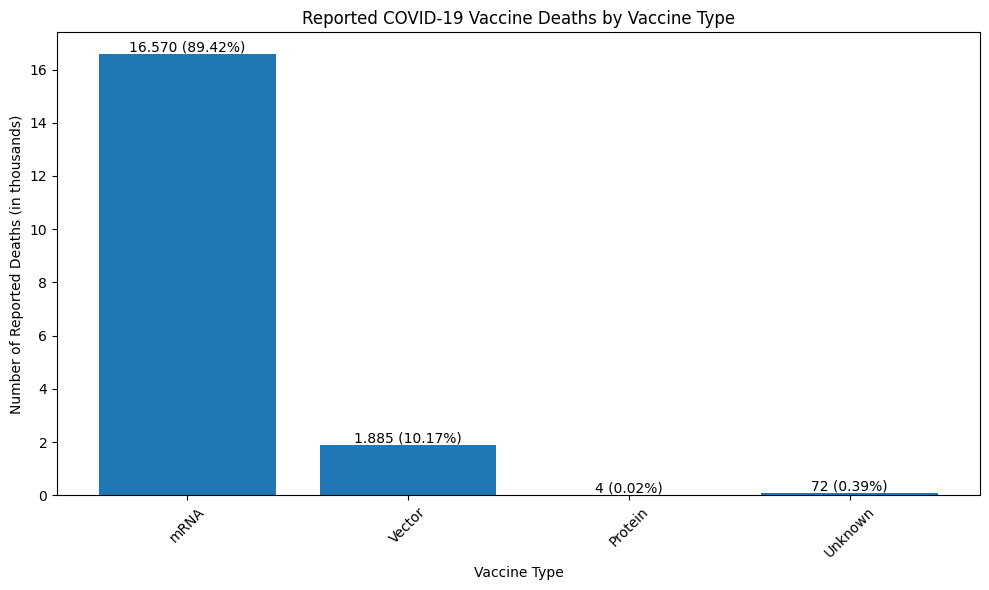

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Initialize a dictionary to store counts of deaths by COVID19 vaccine type
deaths_per_vaccine_type = {'mRNA': 0, 'Vector': 0, 'Protein': 0, 'Unknown': 0}

# Mapping manufacturers to vaccine types
vaccine_type_map = {
    'PFIZER\\BIONTECH': 'mRNA',
    'MODERNA': 'mRNA',
    'JANSSEN': 'Vector',
    'NOVAVAX': 'Protein',
    'UNKNOWN MANUFACTURER': 'Unknown'
    # Add other manufacturers as necessary
}

# Query MongoDB for relevant documents containing COVID19 vaccine data
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1}
documents_cursor = collection.find(query, projection)

# Process documents to count deaths by COVID19 vaccine type
total_deaths = 0
for document in documents_cursor:
    last_covid_vax_entry = None
    for entry in reversed(document.get("vax_data", [])):
        if "COVID19" in entry.get("VAX_TYPE", "").upper():
            last_covid_vax_entry = entry
            break
    
    if last_covid_vax_entry:
        vax_manufacturer = last_covid_vax_entry.get("VAX_MANU", "UNKNOWN MANUFACTURER")
        died = document.get("DIED", "N")

        # Check if the person died
        if died == "Y":
            vaccine_type = vaccine_type_map.get(vax_manufacturer, 'Unknown')
            deaths_per_vaccine_type[vaccine_type] += 1
            total_deaths += 1

# Custom formatter function for y-axis in thousands with a dot
def thousands_formatter(y, pos):
    return f'{int(y / 1000):,}'.replace(',', '.')

# Creating a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(deaths_per_vaccine_type.keys(), deaths_per_vaccine_type.values())
plt.xlabel('Vaccine Type')
plt.ylabel('Number of Reported Deaths (in thousands)')
plt.title('Reported COVID-19 Vaccine Deaths by Vaccine Type')

# Set the y-axis formatter for thousands with a dot
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Annotate each bar with its value and percentage
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')  # Format with a dot for thousands

    if total_deaths != 0:
        percentage = (height / total_deaths) * 100  # Calculate the percentage
        label = f'{formatted_height} ({percentage:.2f}%)'
    else:
        label = formatted_height  # No deaths, just display the count

    plt.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Vaccine_Type.png')
plt.show()


# Percentage of deaths by vaccine type (mRNA vs Vector) (2020 - 2023)

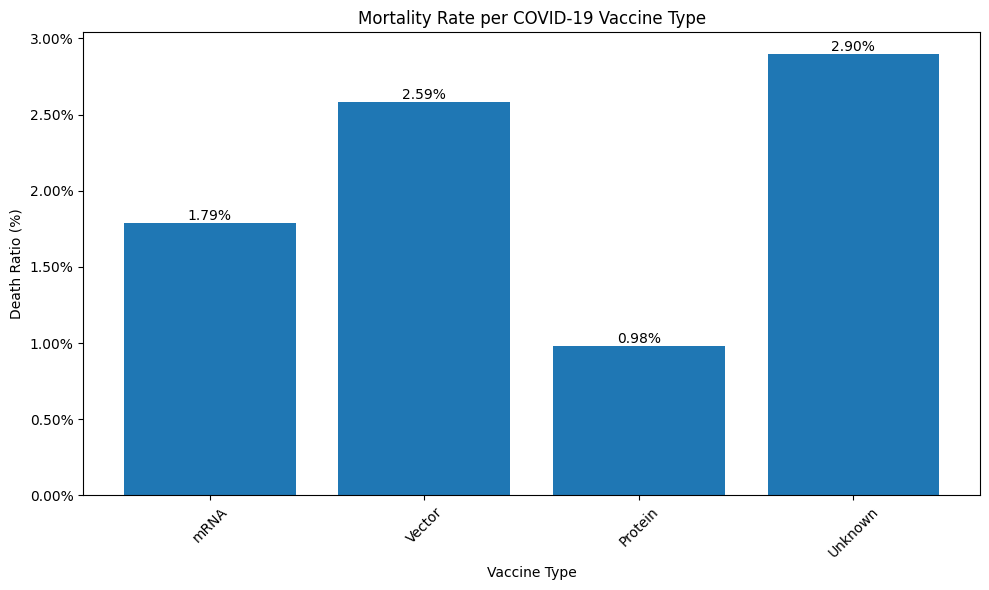

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Mapping manufacturers to vaccine types
vaccine_type_map = {
    'PFIZER\\BIONTECH': 'mRNA',
    'MODERNA': 'mRNA',
    'JANSSEN': 'Vector',
    'NOVAVAX': 'Protein',
    'UNKNOWN MANUFACTURER': 'Unknown'
    # Add other manufacturers as necessary
}

# Query MongoDB for relevant documents containing COVID19 vaccine data
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1}
documents_cursor = collection.find(query, projection)

# Initialize variables to count deaths and total entries by vaccine type
deaths_by_type = {v: 0 for v in vaccine_type_map.values()}
total_entries_by_type = {v: 0 for v in vaccine_type_map.values()}

# Process documents to count deaths and total entries by COVID19 vaccine type
for document in documents_cursor:
    last_covid_vax_entry = None
    for entry in reversed(document.get("vax_data", [])):
        if "COVID19" in entry.get("VAX_TYPE", "").upper():
            last_covid_vax_entry = entry
            break
    
    if last_covid_vax_entry:
        vax_manufacturer = last_covid_vax_entry.get("VAX_MANU", "UNKNOWN MANUFACTURER")
        died = document.get("DIED", "N")
        vaccine_type = vaccine_type_map.get(vax_manufacturer, 'Unknown')

        # Update total entries count for the vaccine type
        total_entries_by_type[vaccine_type] += 1

        # Check if the person died
        if died == "Y":
            # Update deaths count for the vaccine type
            deaths_by_type[vaccine_type] += 1

# Custom formatter function for y-axis in percentage
def percentage_formatter(y, pos):
    return f'{y:.2f}%'

# Creating a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(deaths_by_type.keys(), [deaths_by_type[v] / total_entries_by_type[v] * 100
                                        for v in deaths_by_type.keys()])
plt.xlabel('Vaccine Type')
plt.ylabel('Death Ratio (%)')
plt.title('Mortality Rate per COVID-19 Vaccine Type')

# Set the y-axis formatter for percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Deaths by age group (2020 - 2023)

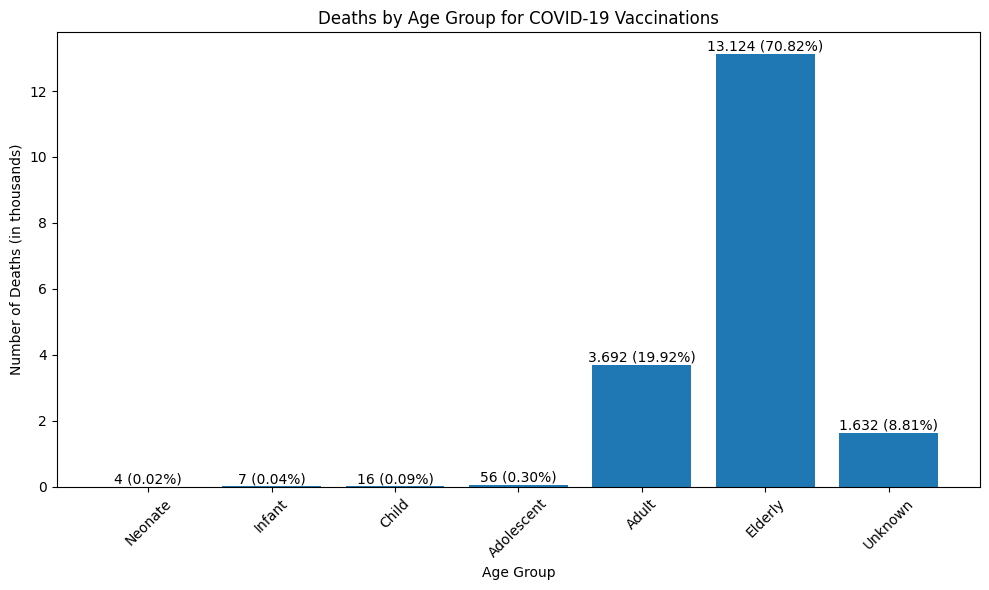

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Initialize a dictionary to store the age group counts for deaths
age_group_deaths = {
    'Neonate': 0, 'Infant': 0, 'Child': 0, 'Adolescent': 0, 'Adult': 0, 'Elderly': 0, 'Unknown': 0
}

# Query MongoDB for relevant documents containing COVID19 vaccine data
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1, "AGE": 1}
documents_cursor = collection.find(query, projection)

# Process documents to count deaths by age group
for document in documents_cursor:
    age = document.get("AGE")
    died = document.get("DIED", "N")

    # Categorize age into age groups
    age_group = categorize_age(age)

    # Update the count of deaths for the corresponding age group
    if died == "Y":
        age_group_deaths[age_group] += 1

# Custom formatter to display values in thousands
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}'

# Plotting the data 
plt.figure(figsize=(10, 6))
bars = plt.bar(age_group_deaths.keys(), age_group_deaths.values())
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths (in thousands)')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.title('Deaths by Age Group for COVID-19 Vaccinations')

# Annotate each bar with the raw number formatted with a dot as the thousands separator
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')  # Format with a dot for thousands
    percentage = (height / total_deaths) * 100  # Calculate the percentage
    label = f'{formatted_height} ({percentage:.2f}%)'
    plt.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Age_Group.png')
plt.show()

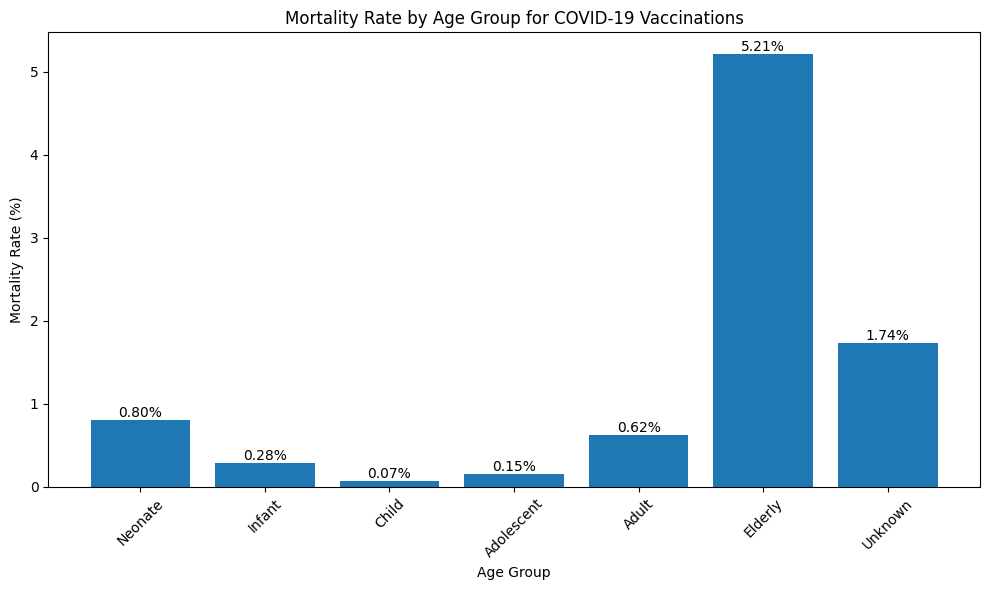

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Initialize a dictionary to store the age group counts for deaths
age_group_deaths = {
    'Neonate': 0, 'Infant': 0, 'Child': 0, 'Adolescent': 0, 'Adult': 0, 'Elderly': 0, 'Unknown': 0
}

# Initialize a dictionary to store the age group counts for total vaccine recipients
age_group_vaccinated = {
    'Neonate': 0, 'Infant': 0, 'Child': 0, 'Adolescent': 0, 'Adult': 0, 'Elderly': 0, 'Unknown': 0
}

# Query MongoDB for relevant documents containing COVID19 vaccine data
query = {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
projection = {"vax_data.$": 1, "DIED": 1, "AGE": 1}
documents_cursor = collection.find(query, projection)

# Process documents to count deaths and total vaccine recipients by age group
for document in documents_cursor:
    age = document.get("AGE")
    died = document.get("DIED", "N")

    # Categorize age into age groups
    age_group = categorize_age(age)

    # Update the count of deaths for the corresponding age group
    if died == "Y":
        age_group_deaths[age_group] += 1

    # Update the count of vaccine recipients for the corresponding age group
    age_group_vaccinated[age_group] += 1

# Calculate the mortality rate per age group
mortality_rate_per_age_group = {}
for age_group in age_group_deaths.keys():
    deaths = age_group_deaths[age_group]
    vaccinated = age_group_vaccinated[age_group]
    mortality_rate_per_age_group[age_group] = (deaths / vaccinated) * 100 if vaccinated > 0 else 0

# Plotting the data 
plt.figure(figsize=(10, 6))
bars = plt.bar(mortality_rate_per_age_group.keys(), mortality_rate_per_age_group.values())
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')

plt.title('Mortality Rate by Age Group for COVID-19 Vaccinations')

# Annotate each bar with the mortality rate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Relative_Death_Ratio_by_Age_Group.png')
plt.show()


In [51]:
# Initialize a list to store VAERS_IDs of people who died after receiving the NOVAVAX vaccine
novavax_deaths_vaers_ids = []

# Query MongoDB for documents containing NOVAVAX vaccine data and where the person died
query = {
    "vax_data.VAX_MANU": "NOVAVAX",
    "DIED": "Y"
}

projection = {"VAERS_ID": 1}

documents_cursor = collection.find(query, projection)

# Iterate over the documents to extract the VAERS_IDs
for document in documents_cursor:
    vaers_id = document.get("VAERS_ID")
    if vaers_id:
        novavax_deaths_vaers_ids.append(vaers_id)

# Print the VAERS_IDs
print("VAERS IDs for people who died after receiving the NOVAVAX vaccine:")
for vaers_id in novavax_deaths_vaers_ids:
    print(vaers_id)


VAERS IDs for people who died after receiving the NOVAVAX vaccine:
2718399
2726341
2726346
2726501
